In [1]:
# input : model type, data set
# output : ROC,PQC,AUC,SHAP
# parameter : model parameter, shape sampling number


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
import pandas as pd
import glob


# for data analysis 
from sklearn.model_selection import train_test_split

from changepy import pelt

# importance
from sklearn.inspection import permutation_importance
import shap

In [2]:
#file_type =  {
#  "Id_Time_Label_Data", if filename = ***_nnt.csv, This data type is non divided time series data. NEED window_size.
#  "Id_Time_Data", if filename = ***_lnt.csv, This data type is labels  and  non divided time series data. NEED window_size.
#}

#  y[*] = -1 ->  control (all time point is normal) data 
#  y[t] = 1 ->  normal data 
#  y[t] = 0 ->  anomaly data 


In [3]:
filenames = glob.glob('data/*')
filenames.sort()
filenames


['data/mult_saddle_node_bifurcation_lnt.csv',
 'data/saddle_node_bifurcation_lnt.csv',
 'data/toy_ARmodel_change_lnt.csv',
 'data/toy_linear_change_lnt.csv',
 'data/toy_mean_change_lnt.csv',
 'data/toy_std_change_lnt.csv',
 'data/toy_structure_change_lnt.csv']

# transform data format to 

- x_test: \[ x_1...,x_N \](list), x_i in R^{T_i \times n} (numpy.array)
- y_test: \[ y_1...,y_N\](list), y_i in R^{T_i} (numpy.array)
- x_train : \[ x_1...,x_Nc \](list), x_i in R^{T_i \times n} (numpy.array)

In [4]:
# file type check and data 
# if filename.split('_')[-1] == 'lnt.csv':
#     x_data ,y_data = get_data_ldt(df)
#     LABLE_TYPE = 'LABEL'
# elif filename.split('_')[-1] == 'lnt.csv':
#     x_data ,y_data = get_data_lnt(df,window_size = window_size)
#     LABLE_TYPE = 'LABEL'    

In [5]:
import numpy as  np
import pandas  as pd
import sys
from numpy.lib.stride_tricks import sliding_window_view
from multiprocessing import Pool

class TimeData():    
    dim = 0 # dimention  of state
    N = 0 # number of time series data
    num_data = np.array([],dtype = int) # time length of each data 
    x_data = [] # main time series data
    y_data = [] # time series label data
    id_data = [] # non time-series label data
    
    
    def __init__(self,x_data = None, y_data = None, id_data=None):
        if (x_data is not None) and (y_data is not None) and (id_data is not None):
            self.x_data = x_data
            self.y_data = y_data
            self.id_data = id_data
            self.dim =  x_data[0].shape[1]
            self.N =  len(x_data)
            self.num_data  =  np.array([x_data[i].shape[0] for i in range(self.N)],dtype = int)
            self.doctor()

# show the basic statas
    def show(self):
        print(f' State dimention : {self.dim}')
        print(f' Number of data : {self.N}')
        print(f' Each time length : {self.num_data}')
        print(f' IDs : {np.unique(self.id_data,return_counts=True)}')

    
    def doctor(self):        
        # data number check
        if (len(self.x_data) != self.N) or (len(self.y_data) != self.N) or (len(self.id_data) != self.N):
            print(f'Error : data dimention is not same, x_data :{len(self.x_data)}, y_data :{len(self.y_data)}, id_data :{len(self.id_data)}',file=sys.stderr)
            sys.exit(1)
        for i in range(self.dim):
            # data number check
            if self.x_data[i].shape[1] != self.dim:
                print('Error : state dimention is not same',file=sys.stderr)
                sys.exit(1)            
            # state dimention check            
            if (self.x_data[i].shape[0] != self.num_data[i]) or (self.y_data[i].shape[0] != self.num_data[i]):
                print('Error : num_data is not correct',file=sys.stderr)
                sys.exit(1)            
        return
    
    def read_csv(self,filename):
        df = pd.read_csv(filename,index_col=0)
        self.read_dataframe(df)
            
    def read_dataframe(self,df):
        # Columns check
        DATA_KEYS = ['id','time','label']  #  dataformat of time series  
        state_keys = [key for key in df.keys().values if key not in DATA_KEYS]
        self.dim =  len(state_keys)

        # split by  IDs
        IDs = list(set(df.id.values))
        IDs.sort()
        self.N = len(IDs)
        self.num_data = np.zeros(self.N)
        x_data = []
        y_data = []
        for i in range(self.N):
            id_data = IDs[i]
            df_id = df[df.id == id_data]
            self.num_data[i] = df_id.shape[0]
            x_data.append(df_id[state_keys].values)
            y_data.append(df_id['label'].values)

        self.num_data = self.num_data.astype(int)
        # make id labeling 
        id_data = [ 'control'  if np.count_nonzero(y_data[i] == -1) else 'mix' for i in range(len(y_data))] 
        # make
        self.x_data = x_data.copy()
        self.y_data = y_data.copy()
        self.id_data = id_data.copy()
        # data check
        self.doctor()
        return

    
    def normalization(self):
        # normalization
        x_mean = np.r_[[self.x_data[i] for i in range(self.N)]].reshape(self.num_data.sum(),-1).mean(0)
        x_std = np.r_[[self.x_data[i] for i in range(self.N)]].reshape(self.num_data.sum(),-1).std(0)
        self.x_data = [(self.x_data[i] - x_mean)/x_std for i in range(self.N)]
        return

    def at_id(self,id_label):
        x_tmp =[self.x_data[i] for i in range(self.N) if self.id_data[i] == id_label]
        y_tmp =[self.y_data[i] for i in range(self.N) if self.id_data[i] == id_label]
        id_tmp =  [self.id_data[i] for i in range(self.N) if self.id_data[i] == id_label]
        return TimeData(x_data=x_tmp,y_data = y_tmp, id_data=id_tmp)
    
    def split(self, rate = 0.5):
        # shuffle
        all_data = list(zip(self.x_data,self.y_data,self.id_data))
        np.random.shuffle(all_data)
        # calc thresh number         
        N_thresh = int(self.N * rate)
        x_tmp1,y_tmp1,id_tmp1 =zip(*all_data[:N_thresh])
        x_tmp2,y_tmp2,id_tmp2 =zip(*all_data[N_thresh:])
        return TimeData(x_tmp1,y_tmp1,id_tmp1),TimeData(x_tmp2,y_tmp2,id_tmp2)

    def flatten(self):
        x_data = np.concatenate([self.x_data[i] for i in range(self.N)])
        y_data = np.concatenate([self.y_data[i] for i in range(self.N)])
        return x_data, y_data

    def sliding_window(self,window_size):
        x_samples = np.r_[[sliding_window_view(self.x_data[i],(window_size,self.dim)).squeeze(1) for i in range(self.N)]]
        x_samples = x_samples.reshape(-1,x_samples.shape[2],x_samples.shape[3])
        #label is end point on each window
        y_samples = np.r_[[self.y_data[i][window_size-1:] for i in range(self.N)]]
        y_samples = y_samples.reshape(-1)
        return x_samples, y_samples

    def each_sliding_window(self,window_size):
        x_samples = [sliding_window_view(self.x_data[i],(window_size,self.dim)).squeeze(1) for i in range(self.N)]
        #label is end point on each window
        y_samples = [self.y_data[i][window_size-1:] for i in range(self.N)]
        return x_samples, y_samples

    def map_time_series(self, func, multi_core = 1):
        if multi_core <= 1:
            result = [func(self.x_data[i]) for i in range(self.N)]
        else:
            with Pool(multi_core) as p:
                result = p.map(func, self.x_data)
        return result
    
    def map_sliding_window(self,window_size,func,padding = 'same',multi_core = 1):
        x_samples = [sliding_window_view(self.x_data[i],(window_size,self.dim)).squeeze(1) for i in range(self.N)]
        if padding == 'same':
            x_samples = [np.r_[x_samples[i][0,np.newaxis] * np.ones((window_size-1,1,1)),x_samples[i]] for i in range(self.N)]
        elif padding is None:
            pass
        else:
            print("Error: padding_type is incorrect")
            sys.exit(1)
            
        if  multi_core <= 1:
            y_predict = [func(x_samples[i]) for i in range(self.N)]
        else:
            with Pool(multi_core) as p:
                y_predict = p.map(func, x_samples)
        return y_predict
    
    def evaluate_chage_point(self,change_point):
        y_predict = np.concatenate([np.concatenate([np.ones(change_point[i]),np.zeros(self.num_data[i] - change_point[i])]) for i in range(self.N)])
        _,y_test = self.flatten()
 
        TP = (y_predict== 1) & (y_test == 1)
        TN = (y_predict== 0) & (y_test == 0)
        FP = (y_predict== 1) & (y_test == 0)
        FN = (y_predict== 0) & (y_test == 1)
        precision = TP.sum() /(TP.sum() +FP.sum())
        recall = TN.sum() /(TN.sum() +FN.sum())
        F1 =  2*precision*recall/(precision + recall)
        df = pd.DataFrame({'precision':[precision],'recall':[recall],'f1_score':[F1]})
        return df
        
        

# TYPE 1: Anomaly time series data detection

In [6]:
# Model
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM
from sklearn.covariance import MinCovDet
from sklearn.metrics import precision_recall_curve
import time

In [7]:
#  score_data + y_data -> prediction, recall ,f1_score
def  score2result(y_data,score_data):
    # list ->  array
    y = np.concatenate([y_data[i] for i in range(len(y_data))])
    score  = np.concatenate([score_data[i] for i in range(len(score_data))])
    #    calc presicion, recall , f1_score
    precision, recall, thresholds =precision_recall_curve(y,score)
    F1 = 2 * precision *recall /(precision + recall + 1e-10)
    # to DataFrame
    result_precision =  [precision[np.argmax(precision)], precision[np.argmax(recall)],precision[np.argmax(F1)]]
    result_recall =  [recall[np.argmax(precision)], recall[np.argmax(recall)],recall[np.argmax(F1)]]
    result_f1 =  [F1[np.argmax(precision)], F1[np.argmax(recall)],F1[np.argmax(F1)]]
    df = pd.DataFrame({'precision':result_precision,'recall':result_recall,'f1_score':result_f1})
    return  df
    

In [8]:
class  SW_KernelDensity():
    name_model =  'KernelDensity'
    type_model = 1
    def __init__(self,window_size):
        self.window_size = window_size

    def fit(self,td:TimeData,max_num = 1000):
        # make sliding window  data
        x_control, _ = td.sliding_window(self.window_size)
        if x_control.shape[0] >max_num:
            x_control = x_control[:max_num]
        # make sliding window                    
        self.kde = KernelDensity()
        self.kde.fit(x_control.reshape(x_control.shape[0],-1))

    def predict(self,x):
        return  self.kde.score_samples(x.reshape(x.shape[0],-1))

    def score(self,td:TimeData,multi_core = 1):
        score_data = td.map_sliding_window(window_size=self.window_size,func=self.predict,multi_core =  multi_core)
        return  score_data

    def evaluation(self,td:TimeData,multi_core = 1):
        score_data = self.score(td,multi_core)
        df_out = score2result(td.y_data,score_data)
        df_out['model_name'] = [self.name_model + '_max_precision',self.name_model + '_max_recall',self.name_model + '_max_f1_score']
        df_out['model_type'] = self.type_model
        return  df_out


class  SW_SVM():
    name_model =  'SVM'
    type_model = 1
    def __init__(self,window_size):
        self.window_size = window_size

    def fit(self,td:TimeData,max_num = 1000):
        # make sliding window  data
        x_control, _ = td.sliding_window(self.window_size)
        if x_control.shape[0] >max_num:
            x_control = x_control[:max_num]
        # make sliding window                    
        self.clf = OneClassSVM(gamma='auto')
        self.clf.fit(x_control.reshape(x_control.shape[0],-1))

    def predict(self,x):
        return  self.clf.score_samples(x.reshape(x.shape[0],-1))

    def score(self,td:TimeData,multi_core = 1):
        score_data = td.map_sliding_window(window_size=self.window_size,func=self.predict,multi_core =  multi_core)
        return  score_data

    def evaluation(self,td:TimeData,multi_core = 1):
        score_data = self.score(td,multi_core)
        df_out = score2result(td.y_data,score_data)
        df_out['model_name'] = [self.name_model + '_max_precision',self.name_model + '_max_recall',self.name_model + '_max_f1_score']
        df_out['model_type'] = self.type_model
        return  df_out



# TYPE 2: change point detection


##References

[Truong2020] Truong, C., Oudre, L., & Vayatis, N. (2020). Selective review of offline change point detection methods. Signal Processing, 167. [abstract] [doi] [pdf]

[Killick2012] Killick, R., Fearnhead, P., & Eckley, I. (2012). Optimal detection of changepoints with a linear computational cost. Journal of the American Statistical Association, 107(500), 1590–1598.

In [9]:
import ruptures as rpt

class  DP_SAR():
    name_model =  'Dynamic_Programing_Switching_AR'
    type_model = 2

    def __init__(self,p =2):
        self.p = p
        return
     
    def predict(self,x):
        algo = rpt.Dynp(model = 'ar',params={"order": self.p}).fit(x)
        return  algo.predict(1)[0]
    def change_point(self,td,core_num = 1):
        change_point = td.map_time_series(self.predict ,multi_core=core_num)
        return change_point
    
    def evaluation(self,td,core_num = 1):
        change_point = self.change_point(td,core_num)
        df_out =  td.evaluate_chage_point(change_point)
        df_out['model_name'] = self.name_model
        df_out['model_type'] =  self.type_model
        return  df_out


class  DP_Linear():
    name_model =  'Dynamic_Programing_Switching_linear'
    type_model = 2

    def __init__(self):
        return
     
    def predict(self,x):
        algo = rpt.Dynp(model = 'linear').fit(x)
        return  algo.predict(1)[0]
    def change_point(self,td,core_num = 1):
        change_point = td.map_time_series(self.predict ,multi_core=core_num)
        return change_point
    
    def evaluation(self,td,core_num = 1):
        change_point = self.change_point(td,core_num)
        df_out =  td.evaluate_chage_point(change_point)
        df_out['model_name'] = self.name_model
        df_out['model_type'] =  self.type_model
        return  df_out




# TYPE 3

In [10]:

#  each model : TimeData ->  change point score series 

def score2change_point(a):
    return [np.argmax(a[i]) for i in range(len(a))]

    

In [11]:
class SingularSpectrumAnalysis():    
    name_model =  'Singular_Spectrum_Analysis'
    type_model = 3
    def __init__(self,window_size=20):
        self.window_size = window_size
        
    def  predict(self,td:TimeData,num_ref = None,num_test= None,  lag = None, r = 3,m = 3):
        window_size = self.window_size
        if num_ref is None:
            num_ref = int(window_size/2)
        if num_test is None:
            num_test = int(window_size/2)
        if lag is None:
            lag = int(window_size/2)
        x_slide,_ = td.each_sliding_window(window_size)

        a_data = []
        for i in range(td.N):
            a = np.zeros(td.num_data[i] -  lag -num_test - window_size +1)
            for t in range(td.num_data[i] -  lag -num_test - window_size +1):
                X = x_slide[i][t:t+ num_ref]
                Z = x_slide[i][t +lag : t +lag +num_test]
                X = X.reshape(X.shape[0],-1)
                Z = Z.reshape(Z.shape[0],-1)
                U,_,_ = np.linalg.svd(X)
                Q,_,_ = np.linalg.svd(Z)
                _,lambda_XZ,_  = np.linalg.svd(U[:r] @ Q[:m].T)
                a[t] = 1 - lambda_XZ[0]
            a_data.append(np.r_[np.ones(window_size - 1 + num_ref) *a[0],a,a[-1]*np.ones(num_test + num_ref  -lag)])
        return a_data

    def score(self,td:TimeData):
        return self.predict(td)
    
    def evaluation(self,td:TimeData):
        score_data =  self.score(td)
        change_point = score2change_point(score_data)
        df_out =  td.evaluate_chage_point(change_point)
        df_out['model_name'] =  self.name_model
        df_out['model_type'] =  self.type_model
        return df_out
        
        
        
class DNB():    
    name_model =  'DNB'
    type_model = 3
    def __init__(self,window_size=20):
        self.window_size = window_size

    def  predict(self,td:TimeData):
        window_size = self.window_size
        if num_ref is None:
            num_ref = int(window_size/2)
        if num_test is None:
            num_test = int(window_size/2)
        if lag is None:
            lag = int(window_size/2)
        x_slide,_ = td.each_sliding_window(window_size)

        a_data = []
        for i in range(td.N):
            a = np.zeros(td.num_data[i] -  lag -num_test - window_size +1)
            for t in range(td.num_data[i] -  lag -num_test - window_size +1):
                X = x_slide[i][t:t+ num_ref]
                Z = x_slide[i][t +lag : t +lag +num_test]
                X = X.reshape(X.shape[0],-1)
                Z = Z.reshape(Z.shape[0],-1)
                U,_,_ = np.linalg.svd(X)
                Q,_,_ = np.linalg.svd(Z)
                _,lambda_XZ,_  = np.linalg.svd(U[:r] @ Q[:m].T)
                a[t] = 1 - lambda_XZ[0]
            a_data.append(np.r_[np.ones(window_size - 1 + num_ref) *a[0],a,a[-1]*np.ones(num_test + num_ref  -lag)])
        return a_data

    def score(self,td:TimeData):
        return self.predict(td)
    
    def evaluation(self,td:TimeData):
        score_data =  self.score(td)
        change_point = score2change_point(score_data)
        df_out =  td.evaluate_chage_point(change_point)
        df_out['model_name'] =  self.name_model
        df_out['model_type'] =  self.type_model
        return df_out


## STEP 4

In [12]:
from scipy.stats import multivariate_normal

class AR():
    name_model = 'AR_score'
    type_model =  4
    def __init__(self,nty):
    # nty : Length of  time deley
        self.nty = nty # input data

    def  fit(self,td:TimeData):
        self.ny = td.dim
        x_tmp,_ = td.sliding_window(self.nty + 1)
        # X : [times, nty* x_dim + 1 bias]
        X = np.c_[np.ones((x_tmp.shape[0],1)),x_tmp[:,:self.nty].reshape(x_tmp.shape[0],-1),]

        # Y = [times,d_dim]
        Y = x_tmp[:,-1,:]
        self.A =  np.linalg.pinv(X) @ Y
        Y_hat = (X @ self.A)
        self.Sigma =  (Y - Y_hat).T @ (Y - Y_hat) / Y.shape[0]

    def predict_initial_state(self,y):
#          AR type models  do not use u  to predict initial state
        x0  =  y[:self.nty]
        return x0
            
    def predict(self,x0,step = 100):
        x_predict =   np.zeros((step,self.ny))
        x_predict[:self.nty] = x0
        for k in range(step - self.nty):
            x_predict[k+ self.nty] =  np. c_[np.ones(1),x_predict[k:k + self.nty].reshape(1,-1)]  @ self.A
        return  x_predict
    
    def score_func(self,x):
        y_true = x[:,-1]
        x_data = x[:,:-1]
        y_predict  = np. c_[np.ones((x.shape[0],1)),x_data.reshape(x.shape[0],-1)]  @ self.A
        score = np.array([- np.log(multivariate_normal.pdf(y_true[k],mean = y_predict[k],cov = self.Sigma)) for k in range(x.shape[0])])
        return  score 
    
    def score(self,td:TimeData,multi_core = 1):
        return td.map_sliding_window(window_size= self.nty + 1, func = self.score_func,multi_core = multi_core)
     
    def evaluation(self,td:TimeData,multi_core = 1):
        score_data = self.score(td,multi_core)
        df_out = score2result(td.y_data,score_data)
        df_out['model_name'] = [self.name_model + '_max_precision',self.name_model + '_max_recall',self.name_model + '_max_f1_score']
        df_out['model_type'] = self.type_model
        return  df_out


In [13]:
def evaluaiton(td_train,td_test):
    # init
    result_columns = ['model_name','model_type','precision','recall','f1_score']
    df_result = pd.DataFrame(columns=result_columns)
    # type1
    print('Kernel Density')
    model =  SW_KernelDensity(window_size = 10,)
    model.fit(td_train)
    df_out = model.evaluation(td_test,multi_core= 4)
    df_result = pd.concat([df_result,df_out])
    
    print('SVM')
    model =  SW_SVM(window_size = 10,)
    model.fit(td_train)
    df_out = model.evaluation(td_test,multi_core= 4)
    df_result = pd.concat([df_result,df_out])

    # type2
    print('Switching AR')
    model = DP_SAR(2)
    df_out = model.evaluation(td_test,core_num = 4)
    df_result = pd.concat([df_result,df_out])

    print('Switching linear')
    model = DP_Linear()
    df_out = model.evaluation(td_test,core_num = 4)
    df_result = pd.concat([df_result,df_out])

    # tyoe3
    print('SSA')
    model = SingularSpectrumAnalysis(window_size=20)
    df_out = model.evaluation(td_test)
    df_result = pd.concat([df_result,df_out])
    print('')

    # tyoe4
    print('AR')
    model = AR(2)
    model.fit(td_train)
    df_out = model.evaluation(td_test)
    df_result = pd.concat([df_result,df_out])
    return  df_result

In [14]:
filename = filenames[0]
td = TimeData()
td.read_csv(filename)
td.normalization()
td_train =  td.at_id('control')
td_test =  td.at_id('mix')


In [15]:
x_control,_ = td_train.sliding_window(1)
x_samples = td_train.each_sliding_window(10)


In [16]:
np.linalg.eig(np.cov(x_control.squeeze(1).T))


(array([0.00658093, 0.1145504 , 0.74500767, 1.09969954, 1.130223  ]),
 array([[ 9.94822041e-01,  1.01600951e-01,  1.66937817e-03,
          1.40058025e-03, -1.26704116e-03],
        [ 1.01613699e-01, -9.94805254e-01, -3.28963700e-03,
         -4.86057803e-03,  1.64808716e-03],
        [ 1.36383111e-03,  1.99953038e-03, -5.98245303e-01,
          2.78879783e-01,  7.51214194e-01],
        [ 1.31477570e-03,  5.71263059e-03, -5.67968587e-01,
         -8.08862154e-01, -1.52050445e-01],
        [-4.17863599e-04, -1.76675211e-03, -5.65243871e-01,
          5.17631622e-01, -6.42303336e-01]]))

In [ ]:
def two_step(x_test, x_control, **kwargs):
    kwargs = set_auto_params(kwargs)
    if df_expr.shape[1] < 4:
        raise ValueError('experimental group has less than 4 samples.')

    if df_ctrl.shape[1] < 4:
        raise ValueError('experimental group has less than 4 samples.')

    # step 1: deviation filtering
    theta = kwargs["thres_gene_filtering"]
    if kwargs["deviation_metric"] == "mad":
        dev_expr = mad(df_expr)
        dev_ctrl = mad(df_ctrl)
    elif kwargs["deviation_metric"] == "std":
        dev_expr = df_expr.std(axis=1, ddof=0)
        dev_ctrl = df_ctrl.std(axis=1, ddof=0)
    else:
        metr = d["deviation_metric"]
        raise ValueError(
            f"\"{metr}\" for deviation_metric is not supported. Please use \"mad\" or \"std\".")

    sub_idx = df_expr.index[dev_expr > theta * dev_ctrl]
    if len(sub_idx) < 2:  # 0 or 1
        return df_expr.index[0:0]

    # step 2: clustering
    label_arr, freq_sr = clustering(df_expr.loc[sub_idx], **kwargs)
    th = kwargs["thres_cluster_selection"] * freq_sr.iat[0]
    return list(sub_idx[np.isin(label_arr, freq_sr.index[freq_sr > th])]), kwargs


In [68]:
#  shaplet法(凍結中)
#   
# R = 1
# x_data = td_test.x_data

# # def F(S):
# K =  2
# L = 20
# n =  td_test.dim
# N = td_test.N
# S  = np.zeros((K,L,n))
# def dist_S(x):
#     return ((x[:,np.newaxis,:,:] - S[np.newaxis,:,:,:])**2).mean((2,3))

# # x_sample,_ = td_test.each_sliding_window(window_size=L) 
# D = td_test.map_sliding_window(window_size=L,func=dist_S,padding=None)
# M = np.array([D[i].min(0) for i in range(len(D))])
# x =  M.sum(1)

# C = 1/(N * 0.05)
# f_new =   R**2 + C 

In [70]:
x.shape

(1000,)

In [44]:
result_columns = ['data','model_name','model_type','precision','recall','f1_score']
df = pd.DataFrame(columns=result_columns)

for filename in filenames:
    # read_data
    td = TimeData()
    td.read_csv(filename)
    td.normalization()
    # split
    td_train =  td.at_id('control')
    td_test = td.at_id('mix')
    #evaluation 
    df_result = evaluaiton(td_train,td_test)
    df_result['data'] = filename
    df = pd.concat([df,df_result])
    

Kernel Density
SVM
Switching AR
Switching linear
SSA
AR
Kernel Density
SVM
Switching AR
Switching linear
SSA
AR
Kernel Density
SVM
Switching AR
Switching linear
SSA
AR
Kernel Density
SVM
Switching AR
Switching linear
SSA
AR
Kernel Density
SVM
Switching AR
Switching linear
SSA
AR
Kernel Density
SVM
Switching AR
Switching linear
SSA
AR
Kernel Density
SVM
Switching AR
Switching linear
SSA
AR


In [50]:
df =df.reset_index()
df.to_csv('result.csv')


In [24]:
# Research Electronic Data (RED) Capture


In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


In [84]:
precision, recall, thresholds =precision_recall_curve(y_train[:100],model(x_train[:100]))

thresh_pre = thresholds[np.argmax(precision[1:])]
thresh_rec =  thresholds[recall.shape[0] -1 - np.argmax(recall[::-1])]
F1 = 2 * precision *recall /(precision + recall + 1E-10)
threch_F1 =   thresholds[np.argmax(F1)]


In [97]:
from sklearn.neighbors import KernelDensity
import numpy as np
rng = np.random.RandomState(42)
X = rng.random_sample((100, 2))
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
log_density = kde.score_samples(X[:3])
log_density


array([-1.12107052, -0.88517784, -1.06594777])

In [106]:
X_test =  np.random.randn(10,2)  - 1 
kde.score_samples(X_test)


array([ -8.55969828, -10.65183266,  -4.31796406, -14.80627358,
        -3.19572543,  -5.64621077,  -6.04751544,  -8.23796361,
       -10.67229865,  -3.89120565])

In [91]:


# y_train[:100]
# model(x_train[:100])
f1_score(y_train[:100], model(x_train[:100]))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [30]:
x_samples = [sliding_window_view(td_tmp.x_data[i],(window_size,td_tmp.dim)).squeeze(1) for i in range(td_tmp.N)]
x_padding =  [x_samples[i][0,np.newaxis] * np.ones((window_size - 1,1,1)) for i in range(td_tmp.N)]
x_samples =[np.r_[x_padding[i], x_samples[i]] for i in range(td_tmp.N)]

In [42]:
x_padding =  [x_samples[i][0,np.newaxis] * np.ones((window_size - 1,1,1)) for i in range(td_tmp.N)]
x_samples_padding =[np.r_[x_padding[i], x_samples[i]] for i in range(td_tmp.N)]
# x_tmp = np.r_[tmp,x_samples[0]]

In [44]:
x_samples_padding =[np.r_[x_padding[i], x_samples[i]] for i in range(td_tmp.N)]

In [46]:
x_samples_padding[0]

array([[[ 1.47334875],
        [ 0.87163963],
        [-0.22000467],
        [-0.25653784],
        [-0.04762981],
        [-0.68531005],
        [-0.04333007],
        [-0.3140476 ],
        [-2.10325993],
        [-0.79693279]],

       [[ 1.47334875],
        [ 0.87163963],
        [-0.22000467],
        [-0.25653784],
        [-0.04762981],
        [-0.68531005],
        [-0.04333007],
        [-0.3140476 ],
        [-2.10325993],
        [-0.79693279]],

       [[ 1.47334875],
        [ 0.87163963],
        [-0.22000467],
        [-0.25653784],
        [-0.04762981],
        [-0.68531005],
        [-0.04333007],
        [-0.3140476 ],
        [-2.10325993],
        [-0.79693279]],

       [[ 1.47334875],
        [ 0.87163963],
        [-0.22000467],
        [-0.25653784],
        [-0.04762981],
        [-0.68531005],
        [-0.04333007],
        [-0.3140476 ],
        [-2.10325993],
        [-0.79693279]],

       [[ 1.47334875],
        [ 0.87163963],
        [-0.22000467],
   

In [122]:
precision, recall

(array([0.88      , 0.87878788, 0.87755102, 0.87628866, 0.875     ,
        0.87368421, 0.87234043, 0.87096774, 0.86956522, 0.86813187,
        0.86666667, 0.86516854, 0.86363636, 0.86206897, 0.86046512,
        0.85882353, 0.85714286, 0.85542169, 0.85365854, 0.85185185,
        0.85      , 0.84810127, 0.84615385, 0.84415584, 0.84210526,
        0.84      , 0.83783784, 0.83561644, 0.83333333, 0.83098592,
        0.82857143, 0.82608696, 0.82352941, 0.82089552, 0.81818182,
        0.81538462, 0.8125    , 0.80952381, 0.80645161, 0.80327869,
        0.8       , 0.79661017, 0.79310345, 0.78947368, 0.78571429,
        0.78181818, 0.77777778, 0.77358491, 0.76923077, 0.76470588,
        0.76      , 0.75510204, 0.75      , 0.74468085, 0.73913043,
        0.73333333, 0.72727273, 0.72093023, 0.71428571, 0.70731707,
        0.7       , 0.69230769, 0.68421053, 0.67567568, 0.66666667,
        0.65714286, 0.64705882, 0.63636364, 0.625     , 0.61290323,
        0.6       , 0.5862069 , 0.57142857, 0.55

In [123]:
thresholds

array([-52.88863151, -52.23407275, -51.98842964, -51.51958097,
       -51.31699575, -51.08915726, -51.07527585, -50.89423038,
       -50.7608913 , -50.5108243 , -49.77493542, -49.46535719,
       -49.02778666, -48.710886  , -48.33100608, -48.08943386,
       -47.74854504, -47.41207574, -47.39651034, -47.29567408,
       -47.07202506, -47.00502508, -46.99517547, -46.94935578,
       -46.92840086, -46.92621226, -46.89460697, -46.88382622,
       -46.79525017, -46.78364126, -46.77968007, -46.71941358,
       -46.63141464, -46.57436542, -46.37303947, -46.34791932,
       -46.30834458, -46.30782158, -46.29975877, -46.27098788,
       -46.26373644, -46.24913327, -46.2177905 , -46.21129533,
       -46.09418649, -46.02909332, -46.02176321, -46.00765662,
       -45.92012517, -45.9164513 , -45.80404693, -45.78475526,
       -45.74081087, -45.67819562, -45.67735305, -45.65780783,
       -45.65053728, -45.50858037, -45.47787827, -45.47570082,
       -45.42064291, -45.39082239, -45.37098022, -45.35

In [105]:
#  step 3a  If no test data, return the  anomary score


In [103]:
# thresh_ F1 =  thresholds[F1]
F1

array([0.64682003, 0.64590386, 0.64498645, ..., 0.00833333, 0.00417537,
       0.        ])

In [104]:
precision,recall

(array([0.478     , 0.47747748, 0.47695391, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.99790795, 0.9958159 , ..., 0.0041841 , 0.00209205,
        0.        ]))

In [73]:
recall[-1::-1]

(1001,)

In [71]:
recall[::-1]

array([0.        , 0.00209205, 0.0041841 , ..., 0.9958159 , 0.99790795,
       1.        ])

In [150]:
#sliding window 
window_size = 10


x_samples = np.r_[[np.lib.stride_tricks.sliding_window_view(x_data[i],(window_size,x_data[i].shape[1])).squeeze(1) for  i in range(len(x_data))]]
x_samples = x_samples.reshape(-1,x_samples.shape[2],x_samples.shape[3])
y_samples = np.r_[[y_data[i][window_size-1:] for i in range(len(y_data))]]
y_samples = y_samples.reshape(-1)


(2000, 91)

In [57]:
x_samples.shape

(91, 10, 1)

In [7]:
# data split
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size = 0.2)

# make main distribution data
y_unique,y_count= np.unique(y_train, return_counts=True)
y_true = y_unique[y_count.argmax()]
x_train =  x_train[y_train == y_true]

# size reduction
n_samples = 10000

x_train = x_train[:n_samples]
x_test = x_test[:n_samples]
y_test = y_test[:n_samples]

In [8]:
print(f' Unique labels  ={y_unique},\n Unique count  ={y_count}')

 Unique labels  =[0. 1.],
 Unique count  =[51965 20035]


In [10]:
model_types = ['KernelDensity','OneClassSVM','DNB-cov']


model_type = model_types[0]

if model_type == 'KernelDensity':
    kde = KernelDensity()
    kde.fit(x_train.reshape(x_train.shape[0],-1))
    model = lambda x : kde.score_samples(x.reshape(x.shape[0],-1))
elif model_type == 'OneClassSVM':
    clf = OneClassSVM(gamma='auto')
    clf.fit(x_train.reshape(x_train.shape[0],-1))
    model = lambda x : clf.score_samples(x.reshape(x.shape[0],-1))
elif model_type == 'DNB-cov':
    if x_train.shape[2] == 1 :
        model = lambda x : x.std(1).reshape(-1) 
    else :
        model = lambda x : np.array([max(np.linalg.eig(np.cov(x_tmp.T))[0]) for x_tmp in x])    

# prediction
score = model(x_test)


# ROC, PRC
fpr, tpr,_ = roc_curve(y_test, score)
precision, recall,_ = precision_recall_curve(y_test, score)
roc = roc_auc_score(y_test, score)

In [40]:
np.linalg.eig(np.cov(x_train[0].T))

(array([1.20751118e+00, 1.06031036e+00, 5.41248589e-04, 6.84547180e-02,
        4.19941241e-01]),
 array([[ 0.00631557, -0.00508569, -0.99948535, -0.03066086, -0.00481537],
        [ 0.07838123,  0.06265539, -0.02960168,  0.98823359, -0.11157418],
        [-0.50227306,  0.8571281 , -0.00616694, -0.02719928, -0.11079421],
        [-0.03754173, -0.15208295,  0.00828024, -0.0980857 , -0.98273701],
        [-0.86030744, -0.48810924, -0.00679513,  0.10997126,  0.09736853]]))

In [ ]:
# i = 0
# score_sorted_index =np.argsort(score)[::-1]
# for i in range(100):
#     plt.plot(x_test[score_sorted_index[i]])
#     print(score[score_sorted_index[i]],y_test[score_sorted_index[i]])

In [38]:
detector = MinCovDet()
detector.fit(x_test[0])
np.linalg.eig(detector.covariance_)

(array([1.76792784e+00, 5.37071372e-01, 3.56707552e-01, 2.47739499e-04,
        3.06338098e-02]),
 array([[-0.01048324,  0.01557886,  0.01069541, -0.99961699, -0.01728799],
        [ 0.03104423, -0.22797008, -0.13417398,  0.01135472, -0.96381238],
        [-0.61128875,  0.68553212,  0.32319012,  0.02447057, -0.22654165],
        [ 0.73888   ,  0.65785644, -0.08246423,  0.00370162, -0.12027968],
        [ 0.28161813, -0.21226767,  0.93307596,  0.00494218, -0.07055844]]))

In [41]:
detector.predict(x_test[0])

AttributeError: 'MinCovDet' object has no attribute 'predict'

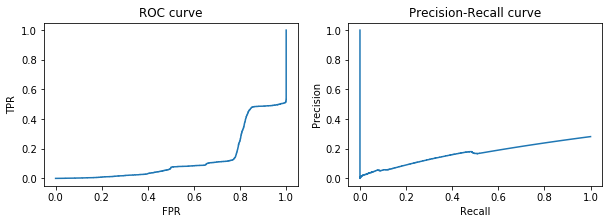

In [11]:
def ROC_PRC(fpr,tpr,precision,recall,figname):
    plt.figure(figsize = (10,3))
    plt.subplot(1,2,1)
    plt.step(fpr, tpr, where='post')
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.subplot(1,2,2)
    plt.step(recall, precision, where='post')
    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(figname)


ROC_PRC(fpr,tpr,precision,recall,figname = 'test.png') 

In [115]:
# sampling for calc shap
num_shap = 10

importance_types = ['SHAP_Class','SHAP_Score']

importance_type = importance_types[0]

if importance_type == 'SHAP_Class':
    #calc shap values of main and error n_sample sample
    x_true_samples = x_test[y_test == y_true]
    x_true_samples = np.random.permutation(x_true_samples)[:num_shap]
    x_false_samples = x_test[y_test != y_true]
    x_false_samples = np.random.permutation(x_false_samples)[:num_shap]

    x_samples = np.r_[x_true_samples,x_false_samples]
    y_samples = np.zeros(2*num_shap)
    y_samples[num_shap:] = 1
elif importance_type == 'SHAP_Score':
    #calc shap values of top and bottom n_sample sample
    score_sorted_index =np.argsort(score)[::-1]

    x_true_samples = x_test[score_sorted_index[-num_shap:]]
    x_false_samples = x_test[score_sorted_index[:num_shap]]

    x_samples = np.r_[x_true_samples,x_false_samples]
    y_samples = np.zeros(2*num_shap)
    y_samples[n_samples:] = 1


    
shap_model = lambda x:model(x.reshape(x.shape[0],-1,x_test.shape[2]))
explainer = shap.explainers.Permutation(shap_model,x_test.reshape(x_test.shape[0],-1))
shap_values = explainer(x_samples.reshape(x_samples.shape[0],-1))
shap_true = shap_values.values[y_samples == 0].reshape(num_shap,x_test.shape[1],-1)
shap_false = shap_values.values[y_samples == 1].reshape(num_shap,x_test.shape[1],-1)


In [116]:
shap_false.shape

(10, 100, 1)

In [123]:
shap_false.shape[1]

100

In [118]:
n_samples

10

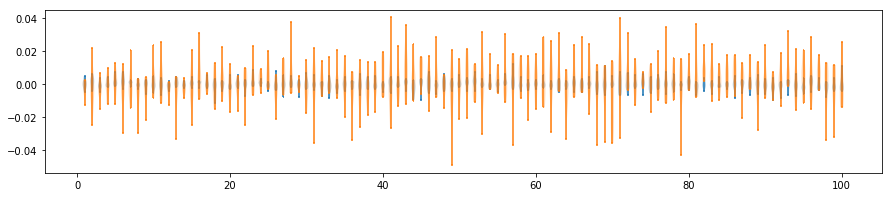

In [125]:
plt.figure(figsize = (0.15 * shap_false.shape[1],3*shap_false.shape[2]))
for i in range(shap_false.shape[2]):
    plt.subplot(i+1,1,shap_false.shape[2])
    plt.violinplot(shap_true[:,:,i])
    plt.violinplot(shap_false[:,:,i])

    plt.show()

In [17]:
from changepy import pelt
from changepy.costs import normal_mean
size = 100

mean_a = 0.0
mean_b = 10.0
var = 1

data_a = np.random.normal(mean_a, var, size)
data_b = np.random.normal(mean_b, var, size)
data = np.append(data_a, data_b)

pelt(normal_mean(data, var), len(data))

[0, 100]

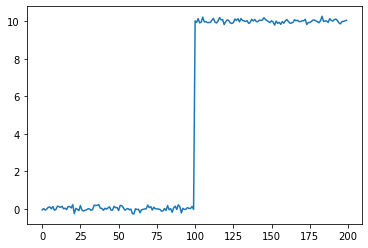

In [13]:
plt.plot(data)

In [14]:
normal_mean(data, var)

<function changepy.costs.normal_mean.<locals>.cost(start, end)>